In [1]:
from SafeTransformer import SafeTransformer
from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import random

In [2]:
data = load_boston()

In [3]:
X = pd.DataFrame(data.data, columns=data.feature_names)

In [4]:
y = data.target

In [11]:
random.seed(123)
X_train, X_test, y_train, y_test = train_test_split(X, y)
surrogate_model = GradientBoostingRegressor(n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    loss='huber')

In [12]:
linear_model = LinearRegression()
safe_transformer = SafeTransformer(surrogate_model, penalty = 0.84)
pipe = Pipeline(steps=[('safe', safe_transformer), ('linear', linear_model)])
pipe = pipe.fit(X_train, y_train)
predictions = pipe.predict(X_test)

mean_squared_error(y_test, predictions)


15.469403476475291

In [13]:
linear_model_standard = LinearRegression()
linear_model_standard = linear_model_standard.fit(X_train, y_train)
standard_predictions = linear_model_standard.predict(X_test)

mean_squared_error(y_test, standard_predictions)

23.145116950516549

In [14]:
safe_transformer.summary('CRIM')

Numerical Variable CRIM
Selected intervals:
	[-Inf, 4.79)
	[4.79, 9.21)
	[9.21, 15.83)
	[15.83, 19.14)
	[19.14, 33.13)
	[33.13, Inf)


# Further model optimization

In [15]:
best_score = float('Inf')
best_pen = 0
errors = []
pens = np.linspace(0.01, 10, 25)
surrogate_model = surrogate_model.fit(X_train, y_train)
for pen in pens:
    safe_transformer = SafeTransformer(surrogate_model, penalty = pen)

    safe_transformer = safe_transformer.fit(pd.DataFrame(X_train))

    X_train_transformed = safe_transformer.transform(X_train)

    X_test_transformed = safe_transformer.transform(X_test)

    linear_model_transformed = LinearRegression()

    linear_model_transformed = linear_model_transformed.fit(X_train_transformed, y_train)

    surrogate_predictions = linear_model_transformed.predict(X_test_transformed)
    error = mean_squared_error(y_test, surrogate_predictions)
    errors.append(error)
    print(error)
    if error < best_score:
        best_score = error
        best_pen = pen

54.0383401743
18.944354189
16.2210232237
14.0056336548
14.1645050318
14.9872230153
16.0082287786
16.1762258372
14.8693881516
14.6128416086
15.3275652519
14.4587309902
14.6947629712
15.2493976745
15.2493976745
15.247673793
15.1592807884
15.1592807884
15.1592807884
15.230656234
15.1872542195
14.769688101
15.0916977619
15.080324415
14.3536399397


In [16]:
gb_predictions = surrogate_model.predict(X_test)
print(mean_squared_error(y_test, gb_predictions))

5.58626943782


In [17]:
import matplotlib.pyplot as plt

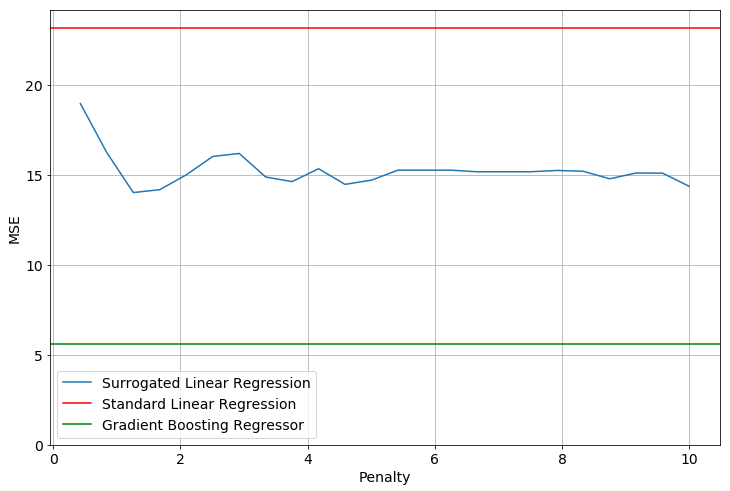

In [18]:
standard_error = mean_squared_error(y_test, standard_predictions)
xgb_error = mean_squared_error(y_test, gb_predictions)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': 14})
plt.plot(pens[1:], errors[1:], label='Surrogated Linear Regression')
plt.xlabel('Penalty')
plt.ylabel('MSE')
plt.grid(True)
plt.axhline(standard_error, color='r', label='Standard Linear Regression')
plt.axhline(xgb_error, color='g', label='Gradient Boosting Regressor')
plt.ylim((0, max(max(errors[1:])+1, standard_error+1)))
plt.legend()
plt.show()